In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from base_hTCN import base_hTCN
from sklearn import metrics
import torch.distributions as dist



# Hyperparams

In [2]:
train_T = 40000
test_T = 4000
T_no = 100
M_no = 2
B_no = 2

C_den = torch.zeros(5,5)
C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))
#C_den = torch.zeros(2,2)
#C_den[0,1:] = 1


sub_no = C_den.shape[0]

batch_size = 1500

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])

#Ensyn = torch.tensor([0, 106+ 213+ 211+ 99])
#Insyn = torch.tensor([1, 22+ 36+ 42+ 19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
    
#######
#####
#C_syn = torch.hstack((C_syn_e, C_syn_i))

# Train

In [4]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:]
#V_ref = np.fromfile("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
#V_ref = V_ref[1:]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([4000])


In [5]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.25
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [6]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

#######
#######
#train_S = torch.hstack((train_S_E, train_S_I)).float()
#test_S = torch.hstack((test_S_E, test_S_I)).float().cuda()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

77000
77000


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


465


In [9]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref.flatten())
    #loss = torch.mean((batch_pred -  batch_ref) ** 2)
    
    loss = loss 
    
    loss.backward()
    #for name, p in model.named_parameters():
        #print(name, p.grad)

    
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #if i%100 == 0:
            #torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/burst_L23_sub5_m2_i"+str(i)+".pt")
            #loss_array[i//100,0] = i
            #loss_array[i//100,1] = test_score
            #np.save("/media/hdd01/sklee/tcn/burst_L23_sub5_m2_test_scores.npy", loss_array)


<ipython-input-9-edcead2d1afd>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 40.27551532091377 -0.011028402280832461 -0.031284213066101074
TEST 100 36.90877138993032 0.07348631354160817 0.10205799341201782
TEST 200 33.635225219137716 0.15566150405583545 0.20635855197906494
TEST 300 30.241329154250014 0.24085781479566926 0.297296404838562
TEST 400 26.272648562857547 0.3404828291947788 0.37547188997268677
TEST 500 23.351441675647 0.4138133157553556 0.3573407530784607
TEST 600 21.5221056341897 0.4597347815274109 0.43516045808792114
TEST 700 20.591539789716823 0.483094594532805 0.5732686519622803
TEST 800 18.433123011484994 0.5372769096944499 0.5983614921569824
TEST 900 17.490942243572697 0.5609282897119781 0.5429090261459351
TEST 1000 15.854442578446852 0.6020090214043168 0.6583067178726196
TEST 1100 15.115631743546867 0.6205552458675785 0.6304709315299988
TEST 1200 13.886847173489091 0.6514011851087178 0.715828537940979
TEST 1300 12.666281837712912 0.6820407986150179 0.7512252330780029
TEST 1400 12.04409887455701 0.6976593361675454 0.6833533048629761
TEST 

KeyboardInterrupt: 

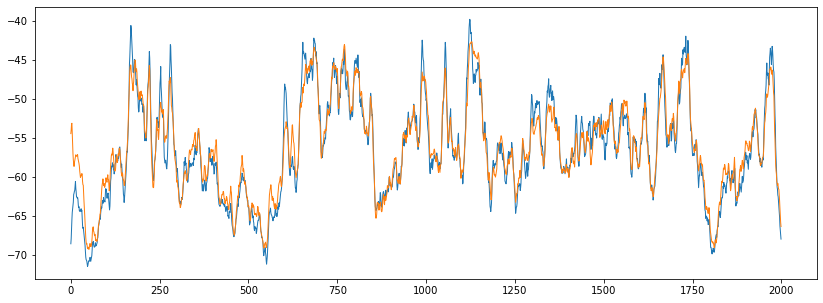

In [13]:
plt.figure(figsize=(14,5))
plt.plot(test_V_ref.cpu().detach().numpy()[:2000], linewidth=1)
plt.plot(test_pred.cpu().detach().numpy()[:2000] - 54, linewidth=1)
#plt.ylim(-100,0)

torch.Size([10, 100])


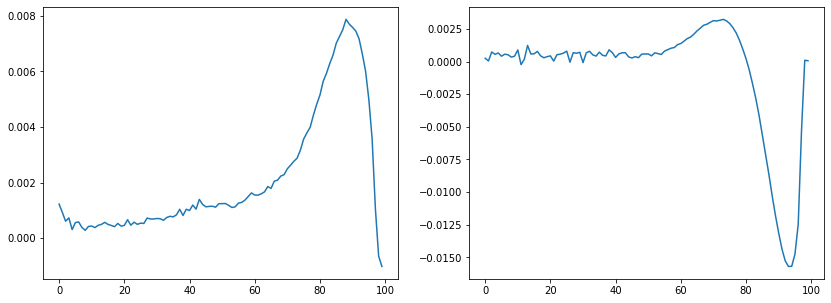

In [19]:
e_weights = torch.matmul(model.conv1_e_weights, model.conv1_e_bases)
i_weights = torch.matmul(model.conv1_i_weights, model.conv1_i_bases)
print(e_weights.shape)

fig, axs = plt.subplots(ncols=2, figsize = (14,5))
axs[0].plot(e_weights[7,:].cpu().detach().numpy())
axs[1].plot(i_weights[7,:].cpu().detach().numpy())

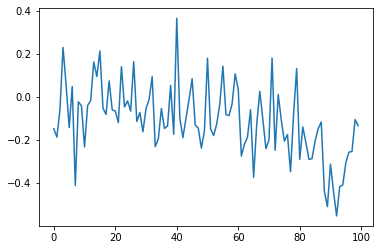

In [13]:
plt.plot(model.conv1_e_bases[0].cpu().detach().numpy())

In [22]:
print(model.conv1_e_weights)
print(model.conv1_e_weights.shape)

Parameter containing:
tensor([[ 0.0025, -0.1957],
        [ 0.0243,  0.0243],
        [ 0.0301,  0.0257],
        [ 0.0235,  0.0223],
        [ 0.0276,  0.0287]], device='cuda:0', requires_grad=True)
torch.Size([5, 2])
